In [1]:
import sys
sys.path.append("..")

In [2]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import xgboost
from satreeverify.xgb_utils import *
from satreeverify.utils import disc_data, get_x_adv

/home/masoud/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Train a XGBoost model

In [3]:
data = load_breast_cancer()
X = data['data']
y = data["target"]
feature_names = data["feature_names"]
y = y==1

In [4]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [5]:
ntrees = 50
clf = xgboost.XGBClassifier(n_estimators=ntrees, max_depth=3).fit(x_train, y_train)
clf.score(x_test, y_test)

/home/masoud/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:29:30] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.9649122807017544

# Discretize the input data

In [6]:
dump = clf.get_booster().get_dump(dump_format="json")
all_thresh = get_ens_thresh(dump)
data_ = disc_data(x_train[:2,:], all_thresh)
print(data_.shape)
data_.head()

(2, 124)


,27_0.14199999,28_0.296299994,1_19.8299999,1_19.7900009,25_0.1479,3_696.25,4_0.0887549967,6_0.0971300006,27_0.0922899991,26_0.320749998,...,28_0.289849997,20_14.8549995,13_40.2200012,26_0.190699995,3_694.5,21_26.2750015,1_20.2999992,13_33.0049973,18_0.0146249998,1_16.6100006
0,False,True,False,False,True,False,True,False,False,False,...,True,True,False,True,False,False,False,False,True,False
1,False,False,False,False,True,False,True,False,True,False,...,False,False,False,False,False,False,False,False,False,False


In [7]:
var_x = {f"x({i})": Bool(f"x({i})") for i in data_.columns}

# Soft Attack
Solving the model using MAX-SAT

In [8]:
epsilon = 0.34
index = 12

sample = X[index:index+1, :]
clf.predict_proba(sample)

array([[9.9902135e-01, 9.7863900e-04]], dtype=float32)

In [9]:
s, c_weights = soft_attack(clf, sample, epsilon, var_x)

In [10]:
adv_weights = get_output(s, c_weights)
1 / (1 + np.exp(-np.sum([v for k, v in adv_weights.items()])))

0.7277125439015879

In [11]:
clf.predict_proba(sample)[0][1]

0.000978639

In [12]:
x_adv, x_adv_sample, compare = get_x_adv(s, var_x, sample)
clf.predict_proba(x_adv_sample)[0][1]

0.7277125

- x_adv is the SAT results
- x_adv_sample is the x_adv transformed to the original input space
- compare is a pandas dataframe that compares the original input and the x_adv_sample

In [13]:
compare.sort_values(by=["diff(%)"], ascending=False)

,0,1,diff(%),bound
23,1332.000000,884.524638,0.335942,"[859.200012, 884.549988]"
1,24.800000,16.593391,0.330912,"[-inf, 16.6100006]"
22,151.700000,101.640039,0.329993,"[91.6949997, 101.649994]"
26,0.363900,0.257466,0.292482,"[0.223450005, 0.257499993]"
27,0.176700,0.135776,0.231601,"[0.111950003, 0.135800004]"
20,20.960000,16.373480,0.218823,"[14.8549995, 16.375]"
9,0.078000,0.061464,0.211996,"[0.0607799999, 0.0614649989]"
21,29.940000,25.513224,0.147855,"[23.7399998, 25.5149994]"
28,0.317600,0.280642,0.116366,"[0.27275002, 0.28065002]"
4,0.097400,0.087557,0.101054,"[-inf, 0.0876449943]"


# Hard Attack

Pure SAT solution, by implementing the ensembling logic.

In XGBoost we compute the positive and negative weights of the trees.

## weight distribution

In [14]:
w = np.asarray([v for k,v in c_weights.items()])
w.min(), w.max()

(-0.582857192, 0.557894766)

(array([ 1.,  6., 17., 25., 63., 58., 32., 17.,  7.,  1.]),
 array([-0.58285719, -0.468782  , -0.3547068 , -0.2406316 , -0.12655641,
        -0.01248121,  0.10159398,  0.21566918,  0.32974437,  0.44381957,
         0.55789477]),
 <BarContainer object of 10 artists>)

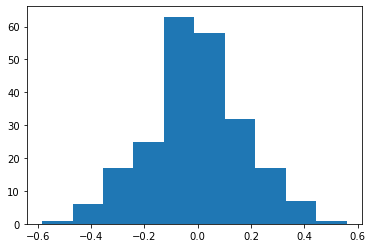

In [15]:
plt.hist(w)

## Attacking sample

In [16]:
epsilon = 0.34
index = 12

nbits = 8
sample = X[index:index+1, :]

In [17]:
s, c_weights, seq_nump, seq_numn = hard_attack(clf, sample, epsilon, var_x, nbits)

In [18]:
clf.predict_proba(sample)[0][1]

0.000978639

In [19]:
adv_weights = get_output(s, c_weights)
val = np.sum([v for k, v in adv_weights.items()])
1 / (1 + np.exp(-val))

0.5706085620174073

In [20]:
x_adv, x_adv_sample, compare = get_x_adv(s, var_x, sample)
clf.predict_proba(x_adv_sample)[0][1]

0.57060856

- x_adv is the SAT results
- x_adv_sample is the x_adv transformed to the original input space
- compare is a pandas dataframe that compares the original input and the x_adv_sample

In [21]:
compare.sort_values(by=["diff(%)"], ascending=False)

,0,1,diff(%),bound
1,24.800000,16.593391,0.330912,"[-inf, 16.6100006]"
22,151.700000,101.640039,0.329993,"[91.6949997, 101.649994]"
20,20.960000,14.840145,0.291978,"[-inf, 14.8549995]"
23,1332.000000,953.630862,0.284061,"[884.549988, 953.700012]"
27,0.176700,0.135776,0.231601,"[0.111950003, 0.135800004]"
9,0.078000,0.060776,0.220815,"[0.057204999, 0.0607799999]"
21,29.940000,25.513224,0.147855,"[23.7399998, 25.5149994]"
28,0.317600,0.272477,0.142074,"[-inf, 0.27275002]"
26,0.363900,0.316515,0.130214,"[0.281750023, 0.316550016]"
4,0.097400,0.088754,0.088769,"[0.0876449943, 0.0887549967]"
